In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

import simulate as sim
import plotting as plot
import observables as obs

# Tests for the autocorrelation and datablocking functions

We test and compare the performance of the autocorrelation and datablocking functions with respect some sinthetic random correlated data. In addition, we also characterize the correlation of our simulation data to be able to improve the autocorrelation and datablocking functions.

In [55]:
def normal_autocorr(N, tau, mu=0., sigma=1.):
    """
    Generates an autocorrelated sequence of Gaussian random numbers.
    
    Each of the random numbers in the sequence of length `N` is distributed
    according to a Gaussian with mean `mu` and standard deviation `sigma` (just
    as in `numpy.random.normal`, with `loc=mu` and `scale=sigma`). Subsequent
    random numbers are correlated such that the autocorrelation function
    is on average `exp(-n/tau)` where `n` is the distance between random
    numbers in the sequence.
    
    This function implements the algorithm described in
    https://www.cmu.edu/biolphys/deserno/pdf/corr_gaussian_random.pdf
    
    Parameters
    ----------
    N: int
        number of desired random numbers
    tau: float
        autocorrelation time
    mu: float
        mean of each Gaussian random number
    sigma: float
        standard deviation of each Gaussian random number
    
    Returns:
    --------
    sequence: numpy array
        array of autocorrelated random numbers
    """
    f = np.exp(-1./tau)
    
    sequence = np.zeros(shape=(N,))
    
    sequence[0] = np.random.normal(0, 1)
    for i in range(1, N):
        sequence[i] = f * sequence[i-1] + np.sqrt(1 - f**2) * np.random.normal(0, 1)
    
    return mu + sigma * sequence

In [94]:
N, tau = 2000, 15 # these values are close to the ones of the simulations
data = normal_autocorr(N, tau)

## Datablocking

In [57]:
b = np.arange(1, 400, dtype=int) # blocks
_, sigma = obs.data_blocking(data, b)

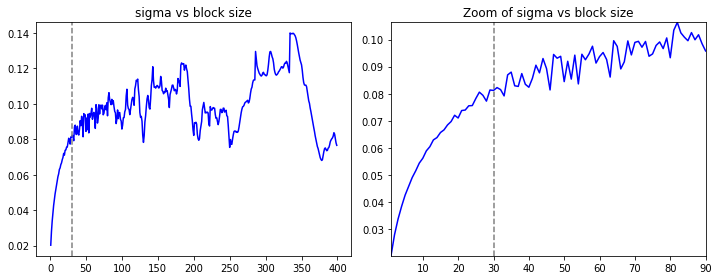

In [58]:
def plotting(b, sigma, tau, fit=None, vlines=None, axis=None, return_axis=False):
    """Plotting the results"""
    if axis is None:
        fig1 = plt.figure(1, figsize=[10,4])
        ax11 = fig1.add_subplot(121)
        ax12 = fig1.add_subplot(122)
    else:
        fig1, ax11, ax12 = axis
    
    ax11.plot(b, sigma, "b-")
    if fit is not None: 
        ax11.plot(b, fit, "r-")
    if vlines is not None:
        for i in vlines:
            ax11.axvline(x=i, linestyle="--")
    ax11.axvline(x=2*tau, color="gray", linestyle="--")
    ax11.set_title("sigma vs block size")
    
    ax12.plot(b, sigma, "b-")
    if fit is not None: 
        ax12.plot(b, fit, "r-")
    if vlines is not None:
        for i in vlines:
            ax12.axvline(x=i, linestyle="--")
    ax12.axvline(x=2*tau, color="gray", linestyle="--")
    ax12.set_xlim(1, 6*tau)
    ax12.set_ylim(np.min(sigma[:int(6*tau)]), np.max(sigma[:int(6*tau)]))
    ax12.set_title("Zoom of sigma vs block size")
    
    fig1.tight_layout()
    
    if return_axis:
        return fig1, ax11, ax12

    return 

plotting(b, sigma, tau)

We will try to use a fitting function to fit the results and then extract the information about the error from the fitting parameters. Fitting all the data does not work because of the large fluctuations at the end and morevoer sometimes it cannot fit the function to the data. We need to first find a better way to limit the range in where to do the fitting. 
For fitting, we have chosen a function that has an asymptote when X --> infinity and that has a similar shape to the data. 

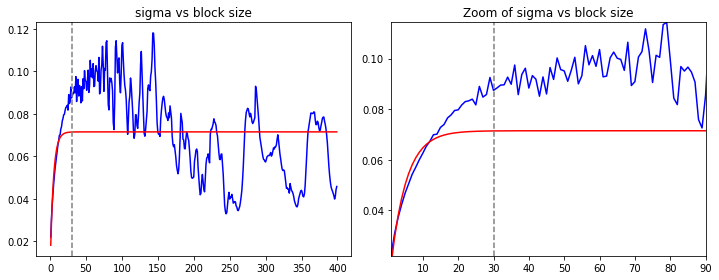

In [22]:
# fitting all data
function = lambda x,a,b,c: b-c*np.exp(-a*x) # function for fitting the error
try:
    popt, _ = optimize.curve_fit(function,  b,  sigma)
    plotting(b, sigma, tau, fit=function(b, *popt))
except:
    print("Error in function fitting")

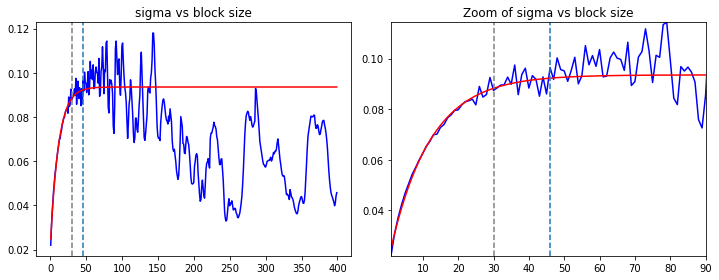

In [32]:
# fitting the beggining of the data
b_negative = np.where(np.diff(sigma) < 0)[0][0] # find first point that decreases
b_max = b_negative*2 # increase the range to have a better fitting
try:
    popt, _ = optimize.curve_fit(function,  b[:b_max],  sigma[:b_max])
    plotting(b, sigma, tau, fit=function(b, *popt), vlines=[b_max])
except:
    print("Error in function fitting")

We can see now that the fitting is much better. But taking b_max as twice as the b_negative is a little bit random. Let's check how to improve it. 

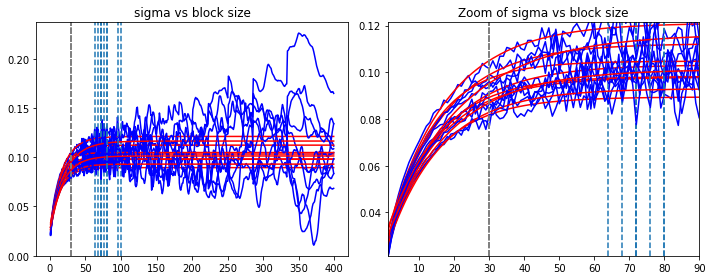

In [45]:
# Repeat for couple of times the procedure
factor_b_max = 4

axis = None
for _ in range(10):
    data = normal_autocorr(N, tau)
    _, sigma = obs.data_blocking(data, b)
    
    b_negative = np.where(np.diff(sigma) < 0)[0][0] # find first point that decreases
    b_max = b_negative*factor_b_max # increase the range to have a better fitting
    popt, _ = optimize.curve_fit(function,  b[:b_max],  sigma[:b_max])
    axis = plotting(b, sigma, tau, fit=function(b, *popt), vlines=[b_max], axis=axis, return_axis=True)   

By manually adjusting the factor_b_max, we can see that with factor_b_max=4 the results are more or less reproducible for all the different data with same tau. 
The error of the data blocking is given by the fitting parameter b (popt[1]), so now we can build our function for extracting the error from the data using data blocking. 

In [53]:
def error_data_blocking(data):
    """
    Returns error from data using data blocking. 

    Parameters
    ----------
    data : np.ndarray(len(time))
        Variable as a function of time

    Returns
    -------
    error : float
        Error of the given variable
    """

    N = len(data)
    b_range = np.arange(2, int(N/2))
    sigma = np.zeros(len(b_range))

    for k, b in enumerate(b_range):
        Nb = int(N/b) 
        data_ = data[:b*Nb]
        blocks = data_.reshape(Nb, b)
        average_blocks = np.average(blocks, axis=1)
        sigma[k] = np.sqrt(((average_blocks**2).sum()/Nb - (average_blocks.sum()/Nb)**2) / (Nb-1)) 

    # fitting
    b_negative = np.where(np.diff(sigma) < 0)[0][0] # find first point that decreases
    b_max = b_negative*4 # increase the range to have a better fitting
    function = lambda x,a,b,c: b-c*np.exp(-a*x) # function for fitting the error
    try: 
        popt, _ = optimize.curve_fit(function,  b[:b_max],  sigma[:b_max])
        error = popt[1]
    except: # just in case there is an error in the fitting
        error = np.max(sigma[:b_max])

    return error

In [54]:
# let's try how reliable it is
ERROR = []
for _ in range(100):
    data = normal_autocorr(N, tau)
    ERROR += [error_data_blocking(data)]
    
print("ERROR = {} +- {}".format(np.average(ERROR), np.std(ERROR)))

ERROR = 0.1183617906931999 +- 0.016685343094554668


We can see that the standard deviation is quite small, so the function is "reliable".

## Autocorrelation function 

In [83]:
t = np.arange(len(data)-1)
Xa = obs.autocorrelation_function(data)

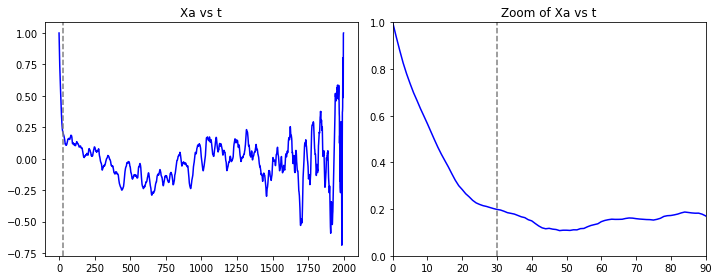

In [77]:
def plotting(t, Xa, tau, fit=None, vlines=None, axis=None, return_axis=False):
    """Plotting the results"""
    if axis is None:
        fig1 = plt.figure(1, figsize=[10,4])
        ax11 = fig1.add_subplot(121)
        ax12 = fig1.add_subplot(122)
    else:
        fig1, ax11, ax12 = axis
    
    ax11.plot(t, Xa, "b-")
    if fit is not None: 
        ax11.plot(t, fit, "r-")
    if vlines is not None:
        for i in vlines:
            ax11.axvline(x=i, linestyle="--")
    ax11.axvline(x=2*tau, color="gray", linestyle="--")
    ax11.set_title("Xa vs t")
    
    ax12.plot(t, Xa, "b-")
    if fit is not None: 
        ax12.plot(t, fit, "r-")
    if vlines is not None:
        for i in vlines:
            ax12.axvline(x=i, linestyle="--")
    ax12.axvline(x=2*tau, color="gray", linestyle="--")
    ax12.set_xlim(0, 6*tau)
    ax12.set_ylim(0, 1)
    ax12.set_title("Zoom of Xa vs t")
    
    fig1.tight_layout()
    
    if return_axis:
        return fig1, ax11, ax12

    return 

plotting(t, Xa, tau)

We see that in this case again we only want to do the fitting of the beginning of the autocorrelation data. In this case, instead of taking the point where the function increases we can also work with the point where the function is close to zero. Another option is to find the point where the function is approx. ln(1/e) so that we can find more or less tau and then take a factor of n*tau to do the fitting. 

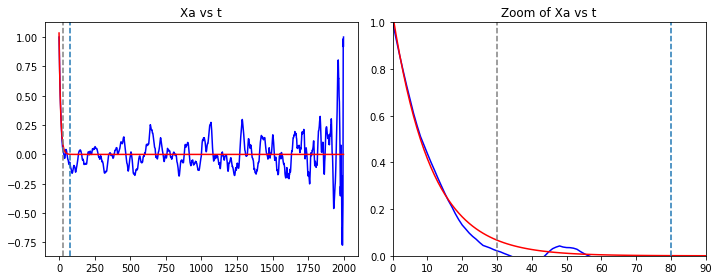

In [86]:
function = lambda x,tau,A: A*np.exp(-x/tau) # function for fitting the error
t_tau = np.where(Xa < 1/np.e)[0][0]
t_max = t_tau*2
try:
    popt, _ = optimize.curve_fit(function,  t[:t_max],  Xa[:t_max])
    plotting(t, Xa, tau, fit=function(t, *popt), vlines=[b_max])
except:
    print("Error in function fitting")

We can see that it works good. Let's check for the reliability by changing the factor of tau. 

TAU = 13.803222252207926 +- 2.5105145653979313


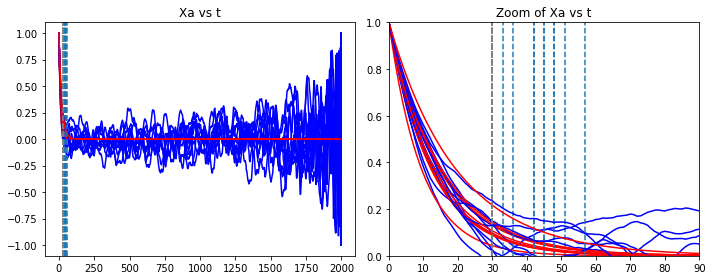

In [95]:
# Repeat for couple of times the procedure
factor_t_max = 3

axis = None
tau_fit = []
for _ in range(10):
    data = normal_autocorr(N, tau)
    t = np.arange(len(data)-1)
    Xa = obs.autocorrelation_function(data)
    
    t_tau = np.where(Xa < 1/np.e)[0][0]
    t_max = t_tau*factor_t_max
    function = lambda x,tau: np.exp(-x/tau) # function for fitting the error
    popt, _ = optimize.curve_fit(function,  t[:t_max],  Xa[:t_max])
    tau_fit += [popt[0]]
    axis = plotting(t, Xa, tau, fit=function(t, *popt), vlines=[t_max], axis=axis, return_axis=True)
    
print("TAU = {} +- {}".format(np.average(tau_fit), np.std(tau_fit)))

By manually adjusting the factor_t_max, we can see that with factor_t_max=3 the results are more or less reproducible for all the different data with same tau and also the average value for the estimator of tau is close to the real value tau=15. The error of the data blocking is given by the fitting parameter tau (popt[0]), so now we can build our function for extracting the error from the data using the autocorrelation function.

In [89]:
def error_autocorrelation(data):
    """
    Returns error from data using autocorrelation function. 

    Parameters
    ----------
    data : np.ndarray(len(time))
        Variable as a function of time

    Returns
    -------
    error : float
        Error of the given variable
    """
    
    # autocorrelation function
    N = len(data)
    Xa = np.zeros(N-1)

    for t in range(N-1):
        n = N - t
        Xa[t] = ((N-t)*(data[:n]*data[t:n+t]).sum() - (data[:n]).sum()*(data[t:n+t]).sum()) /  \
                (np.sqrt((N-t)*(data[:n]**2).sum() - (data[:n].sum())**2) * np.sqrt((N-t)*(data[t:n+t]**2).sum() - (data[t:n+t].sum())**2))

    # error
    t = np.arange(len(data)-1)
    t_tau = np.where(Xa < 1/np.e)[0][0]
    t_max = t_tau*3
    
    function = lambda x,tau: np.exp(-x/tau) # function for fitting the error
    popt, _ = optimize.curve_fit(function,  t[:t_max],  Xa[:t_max])
    tau = popt[0]
    error = np.sqrt(2*tau/N*(np.average(data**2) - np.average(data)**2))
    
    return error

In [90]:
# let's try how reliable it is
ERROR = []
for _ in range(100):
    data = normal_autocorr(N, tau)
    ERROR += [error_autocorrelation(data)]
    
print("ERROR = {} +- {}".format(np.average(ERROR), np.std(ERROR)))

ERROR = 0.12045094282710664 +- 0.018051517973958212


We can see that the standard deviation is quite small, so the function is "reliable".

## Comparison between data blocking and autocorrelation function

We will compare the difference of errors between the two methods of calculating the error. 

In [91]:
ERROR_DB = [] # data blocking
ERROR_AC = [] # autocorrelation

for _ in range(100):
    data = normal_autocorr(N, tau)
    ERROR_DB += [error_data_blocking(data)]
    ERROR_AC += [error_autocorrelation(data)]
    
ERROR_DB, ERROR_AC = np.array(ERROR_DB), np.array(ERROR_AC)
print("ERROR_DB = {} +- {}".format(np.average(ERROR_DB), np.std(ERROR_DB)))
print("ERROR_AC = {} +- {}".format(np.average(ERROR_AC), np.std(ERROR_AC)))
print("ERROR DIFF = {} +- {}".format(np.average(np.abs(ERROR_AC - ERROR_DB)), np.std(np.abs(ERROR_AC - ERROR_DB))))

ERROR_DB = 0.11676201756668071 +- 0.016522874212892034
ERROR_AC = 0.1183054988359009 +- 0.017052442788462366
ERROR DIFF = 0.004353443818092845 +- 0.004785150641633157


We can see that both functions output similar error (small error difference) and therefore we can conclude that they work correctly (assuming that the autocorrelation function works correctly as the fitting of tau outputs a similar value than the true tau). 